In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import joblib

In [4]:
# Load the datasets
train_data = pd.read_csv('/Users/naanahope/Downloads/male_players (legacy).csv',low_memory=False)
test_data = pd.read_csv('/Users/naanahope/Downloads/players_22.csv',low_memory=False)

In [5]:
# Inspect column names
print(train_data.columns)


Index(['player_id', 'player_url', 'fifa_version', 'fifa_update',
       'fifa_update_date', 'short_name', 'long_name', 'player_positions',
       'overall', 'potential',
       ...
       'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk',
       'player_face_url'],
      dtype='object', length=110)


In [6]:
# Display the first few rows to confirm the column names
print(train_data.head())


   player_id                                        player_url  fifa_version  \
0     158023                /player/158023/lionel-messi/150002            15   
1      20801  /player/20801/c-ronaldo-dos-santos-aveiro/150002            15   
2       9014                  /player/9014/arjen-robben/150002            15   
3      41236           /player/41236/zlatan-ibrahimovic/150002            15   
4     167495                /player/167495/manuel-neuer/150002            15   

   fifa_update fifa_update_date         short_name  \
0            2        9/18/2014           L. Messi   
1            2        9/18/2014  Cristiano Ronaldo   
2            2        9/18/2014          A. Robben   
3            2        9/18/2014     Z. Ibrahimović   
4            2        9/18/2014           M. Neuer   

                             long_name player_positions  overall  potential  \
0       Lionel Andrés Messi Cuccittini               CF       93         95   
1  Cristiano Ronaldo dos Santos Avei

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


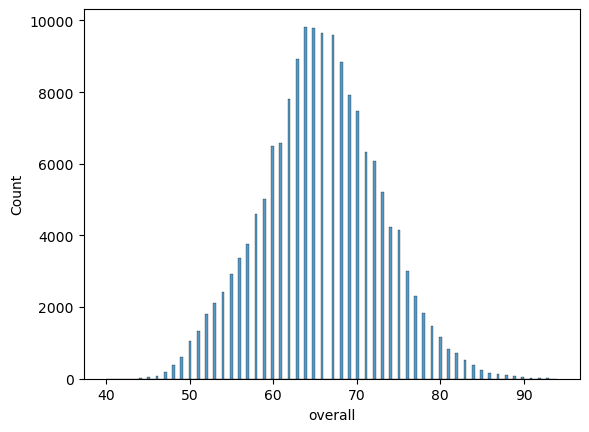

In [7]:
# Plot histogram for the 'overall' column
sns.histplot(train_data['overall'])
plt.show()

In [8]:
# List of columns to be removed if they exist
irrelevant_columns = ['player_id', 'player_url', 'short_name', 'long_name', 'player_face_url', 'fifa_version', 'fifa_update', 'fifa_update_date']

# Drop irrelevant columns from train_data if they exist
train_data = train_data.drop(columns=[col for col in irrelevant_columns if col in train_data.columns])

# Drop irrelevant columns from test_data if they exist
test_data = test_data.drop(columns=[col for col in irrelevant_columns if col in test_data.columns])


In [9]:
# Align test_data with train_data columns
test_data = test_data.reindex(columns=train_data.columns)
test_data

,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,league_id,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,"RW, ST, CF",93,93,78000000.0,320000.0,34,1987-06-24,170,72,NaN,...,64+3,64+3,64+3,66+3,61+3,50+3,50+3,50+3,61+3,19+3
1,ST,92,92,119500000.0,270000.0,32,1988-08-21,185,81,NaN,...,66+3,66+3,66+3,64+3,61+3,60+3,60+3,60+3,61+3,19+3
2,"ST, LW",91,91,45000000.0,270000.0,36,1985-02-05,187,83,NaN,...,59+3,59+3,59+3,63+3,60+3,53+3,53+3,53+3,60+3,20+3
3,"LW, CAM",91,91,129000000.0,270000.0,29,1992-02-05,175,68,NaN,...,63+3,63+3,63+3,67+3,62+3,50+3,50+3,50+3,62+3,20+3
4,"CM, CAM",91,91,125500000.0,350000.0,30,1991-06-28,181,70,NaN,...,80+3,80+3,80+3,79+3,75+3,69+3,69+3,69+3,75+3,21+3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19234,CDM,47,52,70000.0,1000.0,22,1999-01-02,180,64,NaN,...,46+2,46+2,46+2,48+2,48+2,46+2,46+2,46+2,48+2,15+2
19235,CM,47,59,110000.0,500.0,19,2002-03-18,175,70,NaN,...,46+2,46+2,46+2,49+2,48+2,44+2,44+2,44+2,48+2,14+2
19236,CM,47,55,100000.0,500.0,21,2000-02-07,178,72,NaN,...,46+2,46+2,46+2,47+2,47+2,45+2,45+2,45+2,47+2,12+2
19237,ST,47,60,110000.0,500.0,19,2002-04-23,173,66,NaN,...,29+2,29+2,29+2,33+2,32+2,26+2,26+2,26+2,32+2,15+2


In [10]:
# Fill missing values only for numeric columns
numeric_cols = train_data.select_dtypes(include=['number']).columns
train_data[numeric_cols] = train_data[numeric_cols].fillna(train_data[numeric_cols].mean())
test_data[numeric_cols] = test_data[numeric_cols].fillna(train_data[numeric_cols].mean())


In [11]:
# Display the cleaned datasets
print(train_data.head())
print(test_data.head())

  player_positions  overall  potential    value_eur  wage_eur  age        dob  \
0               CF       93         95  100500000.0  550000.0   27  6/24/1987   
1           LW, LM       92         92   79000000.0  375000.0   29   2/5/1985   
2       RM, LM, RW       90         90   54500000.0  275000.0   30  1/23/1984   
3               ST       90         90   52500000.0  275000.0   32  10/3/1981   
4               GK       90         90   63500000.0  300000.0   28  3/27/1986   

   height_cm  weight_kg  league_id  ...   ldm   cdm   rdm   rwb    lb   lcb  \
0        169         67       53.0  ...  62+3  62+3  62+3  62+3  54+3  45+3   
1        185         80       53.0  ...  63+3  63+3  63+3  63+3  57+3  52+3   
2        180         80       19.0  ...  64+3  64+3  64+3  64+3  55+3  46+3   
3        195         95       16.0  ...  65+3  65+3  65+3  61+3  56+3  55+3   
4        193         92       19.0  ...  40+3  40+3  40+3  36+3  36+3  38+3   

     cb   rcb    rb    gk  
0  45+3  4

In [12]:
# Select only numeric columns for correlation calculation
numeric_cols = train_data.select_dtypes(include=[np.number]).columns
numeric_train_data = train_data[numeric_cols]

# Calculate correlation matrix
correlation_matrix = numeric_train_data.corr()

# Select features with high correlation to 'overall'
high_corr_features = correlation_matrix.index[abs(correlation_matrix['overall']) > 0.5]
print(high_corr_features)

# Create a new dataset with these features
train_data_high_corr = train_data[high_corr_features]
test_data_high_corr = test_data[high_corr_features]


Index(['overall', 'potential', 'value_eur', 'wage_eur', 'passing', 'dribbling',
       'movement_reactions', 'mentality_composure'],
      dtype='object')


In [13]:
# Split data into features and target
X_train = train_data_high_corr.drop(columns=['overall'])
y_train = train_data_high_corr['overall']
X_test = test_data_high_corr.drop(columns=['overall'])
y_test = test_data_high_corr['overall']

# Initialize models
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'GradientBoost': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Evaluate models with cross-validation
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print(f'{name} CV RMSE: {np.sqrt(-cv_scores).mean()}')

# Train and evaluate the best model
best_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print(f'Test MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')


RandomForest CV RMSE: 1.827723994235713
XGBoost CV RMSE: 1.9107077409469795
GradientBoost CV RMSE: 1.957602483344403
Test MAE: 1.4966856401069126
Test RMSE: 1.9547507082953237


In [14]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 7]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42),
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best CV RMSE: {np.sqrt(-grid_search.best_score_)}')


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 150}
Best CV RMSE: 1.8203319792261852


In [15]:
# Assume X_train, y_train are already defined from your dataset
# Initialize and train your model
model = GradientBoostingRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save the trained model to a file named 'best_model.pkl'
joblib.dump(model, 'best_model.pkl')



['best_model.pkl']